In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

A function that takes 2 inputs:
+ a dataframe named df (see example below)
+ a shift value in the unit of hour(s), integer, named shift. Shift = 1 means the time in the df is one our later than actual (e.g. logged 6AM should be in fact 7AM locally); shift = -1 means the opposite

Dataframe example:

dataid	local_15min	air1	air2	air3	airwindowunit1	aquarium1	bathroom1	bathroom2	bedroom1	...	sprinkler1	sumppump1	utilityroom1	venthood1	waterheater1	waterheater2	wellpump1	winecooler1	leg1v	leg2v
0	3687	2014-01-01 00:00:00-06	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.239	119.769
1	3687	2014-01-01 00:15:00-06	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.256	119.628
2	3687	2014-01-01 00:30:00-06	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.358	119.859
3	3687	2014-01-01 00:45:00-06	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.766	119.985
4	3687	2014-01-01 01:00:00-06	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.844	120.368
...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...	...
805519	6547	2015-09-30 22:45:00-05	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	121.619	120.179
805520	6547	2015-09-30 23:00:00-05	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	121.167	119.729
805521	6547	2015-09-30 23:15:00-05	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	121.198	120.253
805522	6547	2015-09-30 23:30:00-05	0.000	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.710	119.750
805523	6547	2015-09-30 23:45:00-05	1.434	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	120.240	119.013
805524 rows × 79 columns


the function needs to do this:

1. rename the columns with title local_{anything} to local_minute
2. convert dataid column type to int; create another column named "DST" which is boolean type, default is true
3. group by dataid
4. for each dataid group:
    4.1. check the renamed time stamp col (should be local_minute now, but refers to the local_15min in the sample data above) - there should be a suffix -05 or -06 - these are central time with and without DST. Update the "DST" column value to be false if got -06, otherwise true.
    4.2 remove all suffixes -05 or -06
    4.3 shift all values minus 1 hour (e.g. 6AM-06 -> 5AM-05) for all rows with "DST" being true; else dont do anything
    4.4 you should have gaps in the time series, if you are not luck enough. In this case we need to fill the gap strategically. e.g. if NOV 11 2AM was shifted to NOV 11 1AM and the next record is NOV 11 3:15 unshifted, the gap of 1 hour should be using the copied data from the previous day, same time, with label "DST" being turned off (false)
    4.5 if there are overlapping records (i do not think we should have any), keep the one shifted (DST = true one, but i don think there should any. check it still though)
    4.6 perform additional shift as per the input shift parameter. this is the only location where that input is needed
5. return the cleaned data frame after checking: no overlap or gap time series for each dataid value group; dst labeling

## Time Shift Problem

In [4]:
austin = pd.read_csv("../data/15minute_data_austin.csv")
california = pd.read_csv("../data/15minute_data_california.csv")
newyork = pd.read_csv("../data/15minute_data_newyork.csv")

In [5]:
def clean_dst_and_shift(df: pd.DataFrame, shift: int = 0) -> pd.DataFrame:
    """
    Clean a Dataport-like dataframe by:
      1) Renaming any 'local_*' time column to 'local_minute'
      2) Ensuring dataid is int and creating a boolean 'DST' column
      3) For each dataid group:
         4.1) Detect '-05'/'-06' suffix (CDT/CST) and set DST (True for -05, False for -06)
         4.2) Remove the suffix from the timestamp strings
         4.3) Shift all rows with DST=True backward by 1 hour
         4.4) Fill gaps (15-min grid) by copying previous day’s same time (set DST=False)
         4.5) If overlapping timestamps exist, keep the shifted (DST=True) record
         4.6) Apply additional user-specified shift (in hours)
      5) Return a single cleaned DataFrame with no gaps or overlaps per dataid.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with columns including 'dataid' and a time column named like 'local_*'.
    shift : int
        Additional shift in hours to apply at step 4.6 (positive = later, negative = earlier).

    Returns
    -------
    pd.DataFrame
        Cleaned dataframe with:
          - 'dataid' as int
          - time column 'local_minute' as pandas datetime (naive, uniform 15-min grid)
          - 'DST' boolean label
          - no gaps/overlaps per dataid
    """
    if 'dataid' not in df.columns:
        raise ValueError("Expected a 'dataid' column.")

    out = df.copy()

    # 1) Rename any 'local_*' to 'local_minute' (use the first match)
    local_cols = [c for c in out.columns if c.startswith('local_')]
    if not local_cols:
        raise ValueError("No 'local_*' time column found (e.g., 'local_15min').")
    if 'local_minute' not in out.columns:
        out = out.rename(columns={local_cols[0]: 'local_minute'})

    # 2) Cast dataid and create DST column (default True)
    out['dataid'] = out['dataid'].astype(int)
    out['DST'] = True

    # Helper: process one dataid group
    def _process_group(g: pd.DataFrame) -> pd.DataFrame:
        g = g.copy()
        g = g.reset_index()

        # 4.1) Detect suffix -05 / -06 (support '-05', '-06', '-05:00', '-06:00')
        s = g['local_minute'].astype(str)
        # capture '-05' or '-06' possibly followed by ':00'
        suffix = s.str.extract(r'(-0[56])(?::?00)?$', expand=False)
        # Default True, but per spec: false if -06, otherwise true
        g['DST'] = suffix.eq('-05')

        # 4.2) Remove suffix
        g['local_minute'] = s.str.replace(r'(-0[56])(?::?00)?$', '', regex=True).str.strip()
        g['local_minute'] = pd.to_datetime(g['local_minute'], errors='coerce')

        # 4.3) Shift rows with DST=True backward by 1 hour
        is_dst = g['DST'].fillna(True)  # be permissive: treat unknown as True
        g.loc[is_dst, 'local_minute'] = g.loc[is_dst, 'local_minute'] - pd.Timedelta(hours=1)

        # 4.5) Resolve overlaps: keep the shifted (DST=True) record on duplicate timestamps
        # Sort so DST=True comes first; then drop duplicates keeping first
        g = g.sort_values(['local_minute', 'DST'], ascending=[True, False])
        g = g.drop_duplicates(subset=['local_minute'], keep='first')

        # 4.4) Fill gaps on a 15-min grid using previous day same time (DST=False on filled)
        g = g.sort_values('local_minute')
        idx = pd.date_range(g['local_minute'].min(), g['local_minute'].max(), freq='15min')
        g = g.set_index('local_minute')

        missing = idx.difference(g.index)
        if len(missing) > 0:
            # Candidate fill rows come from previous day same time, if present
            prev_times = [t - pd.Timedelta(days=1) for t in missing]
            available_mask = [pt in g.index for pt in prev_times]
            to_fill_new_index = [t for t, ok in zip(missing, available_mask) if ok]
            from_prev_idx = [pt for pt, ok in zip(prev_times, available_mask) if ok]

            if len(from_prev_idx) > 0:
                fill_rows = g.loc[from_prev_idx].copy()
                fill_rows.index = pd.DatetimeIndex(to_fill_new_index)
                fill_rows['DST'] = False  # label filled rows as non-DST
                g = pd.concat([g, fill_rows], axis=0).sort_index()

        # After one round of filling, verify again; if still missing, raise
        final_idx = pd.date_range(g.index.min(), g.index.max(), freq='15min')
        still_missing = final_idx.difference(g.index)
        if len(still_missing) > 0:
            # print(
            #     f"Unfilled gaps remain: "
            #     f"{len(still_missing)} missing timestamps. Consider providing more context for gap fill."
            # )
            pass

        # 4.6) Apply the user-specified additional shift (hours)
        if shift != 0:
            g.index = g.index + pd.Timedelta(hours=shift)

        # Ensure no overlaps after final shift
        if g.index.has_duplicates:
            # Keep preference to DST=True if duplicates happen to appear again
            g = g.sort_values(['DST'], ascending=[False])
            g = g[~g.index.duplicated(keep='first')]

        # Return with time back as a column named 'local_minute'
        g = g.reset_index().rename(columns={'level_0': 'local_minute'})
        #g = g.drop(columns=['level_1'], errors='ignore')
        return g

    cleaned = out.groupby('dataid', group_keys=True).apply(_process_group, include_groups=False).reset_index()

    # Final sanity: per dataid, ensure no gaps/overlaps
    def _assert_regular(g: pd.DataFrame):
        g = g.copy()
        g = g.reset_index()
        t = g['local_minute'].sort_values()
        diffs = t.diff().dropna()
        if not (diffs == pd.Timedelta(minutes=15)).all():
            print(g['dataid'].iloc[0])
            return g[:0]
            #raise AssertionError(f"Non-regular 15-min series detected.")
        return g
    cleaned.drop(columns=['level_1', 'index'], inplace=True, errors='ignore')
    #cleaned = cleaned.groupby('dataid', group_keys=True).apply(_assert_regular, include_groups=False).reset_index()
    cleaned.drop(columns=['level_1', 'index'], inplace=True, errors='ignore')
    return cleaned



In [6]:
def plot_pv_test(dataset, pv_id, title=''):
    dataset = dataset.copy()
    dataset = dataset[dataset['dataid'] == pv_id]
    plt.figure(figsize=(6, 3))
    if 'local_15min' in dataset.columns:
        col = 'local_15min'
        dt = pd.to_datetime(dataset[col].apply(lambda x: x[:-3]))
        dataset = dataset.copy()
        dataset[col] = dt
    else:
        col = 'local_minute'

    dataset.sort_values(by=col, inplace=True)
    plt.plot(
        dataset[col],
        dataset['solar']
    )
    
    
    plt.xlim(
        pd.Timestamp(dataset[col].min().date()) + pd.Timedelta(days=1),
        pd.Timestamp(dataset[col].min().date()) + pd.Timedelta(days=4)
    )
    plt.title(title)

    plt.xticks(
        pd.date_range(
            pd.Timestamp(dataset[col].min().date()) + pd.Timedelta(days=1),
            pd.Timestamp(dataset[col].min().date()) + pd.Timedelta(days=4),
            freq='6h'
        ),
        [x.strftime('%m-%d-%H:%M') for x in pd.date_range(
            pd.Timestamp(dataset[col].min().date()),
            pd.Timestamp(dataset[col].min().date()) + pd.Timedelta(days=3),
            freq='6h'
        )],
        rotation=90
    )
    plt.grid()

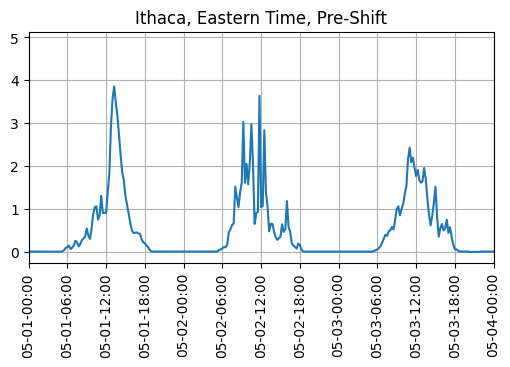

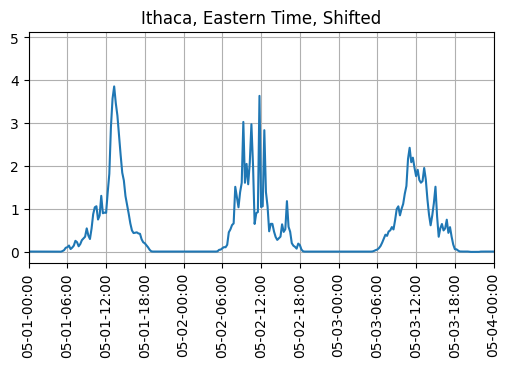

In [7]:
pv_id = newyork.dropna(subset='solar').dataid.unique()[0]
plot_pv_test(newyork, pv_id=pv_id, title='Ithaca, Eastern Time, Pre-Shift')
plot_pv_test(clean_dst_and_shift(newyork, shift=1), pv_id=pv_id, title='Ithaca, Eastern Time, Shifted')

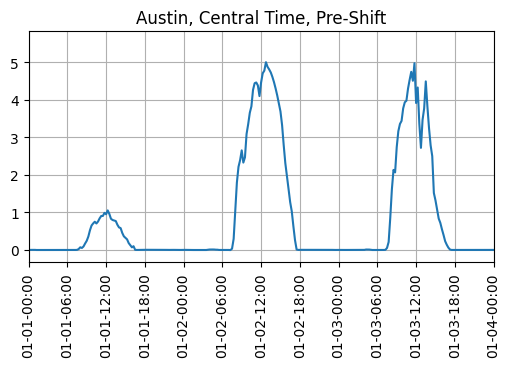

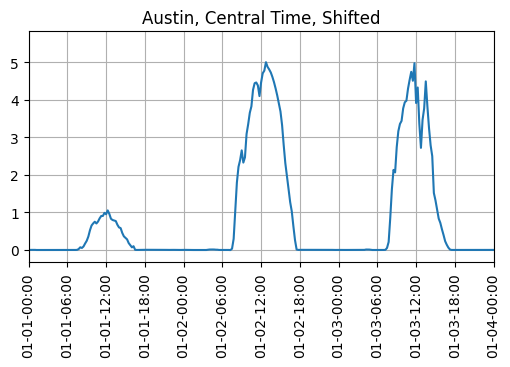

In [8]:
pv_id = austin.dropna(subset='solar').dataid.unique()[0]
plot_pv_test(austin, pv_id=pv_id, title='Austin, Central Time, Pre-Shift')
plot_pv_test(clean_dst_and_shift(austin, shift=0), pv_id=pv_id, title='Austin, Central Time, Shifted')

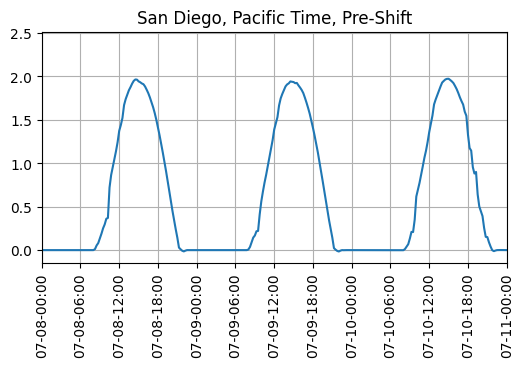

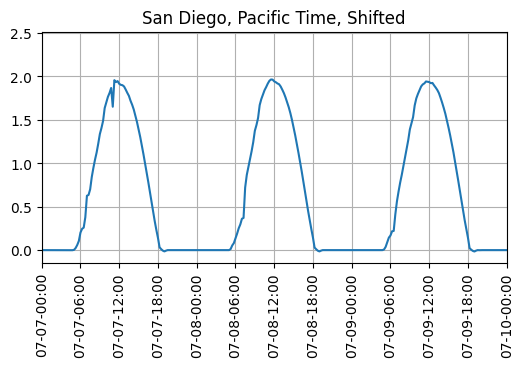

In [9]:
pv_id = california.groupby('dataid')['solar'].sum().sort_values(ascending=False).index[0]
plot_pv_test(california, pv_id=pv_id, title='San Diego, Pacific Time, Pre-Shift')
plot_pv_test(clean_dst_and_shift(california, shift=-2), pv_id=pv_id, title='San Diego, Pacific Time, Shifted')

In [10]:
all_unique_ids = list(set(austin.dataid.unique().tolist() + california.dataid.unique().tolist() + newyork.dataid.unique().tolist()))
metadata = pd.read_csv("../data/metadata.csv")
metadata[metadata['dataid'].isin(all_unique_ids)].groupby(['city', 'state']).size()

city          state     
Austin        Texas         25
Brooktondale  New York       2
Groton        New York       1
Ithaca        New York      18
Lansing       New York       1
San Diego     California    23
Trumansburg   New York       3
dtype: int64

In [11]:
clean_dst_and_shift(newyork, shift=1).to_csv("../data/shifted/15minute_data_newyork_shifted.csv", index=False)
clean_dst_and_shift(austin, shift=0).to_csv("../data/shifted/15minute_data_austin_shifted.csv", index=False)
clean_dst_and_shift(california, shift=-2).to_csv("../data/shifted/15minute_data_california_shifted.csv", index=False)